In [8]:
import pytorch_lightning as pl
import torch as pt

# MUST import tensorflow SECOND or else you will encounter ambiguous error!
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import ChemtabUQ

In [2]:
import torch as pt
from torch import nn
import torch.nn.functional as F
import torchmetrics.functional as F_metrics

def make_MLP(input_size, output_size, batch_norm=True):
    n_layers = 4
    hidden_size = input_size*4

    # fix input size
    bulk_layers = [nn.Linear(input_size,hidden_size)]
    if batch_norm: bulk_layers = [nn.BatchNorm1d(input_size)] + bulk_layers
    
    for i in range(n_layers-1): # this should be safer then potentially copying layers by reference...
        bulk_layers.extend([nn.SELU(), nn.Linear(hidden_size,hidden_size)])

    # build & fix output size
    regressor = nn.Sequential(*bulk_layers, nn.Linear(hidden_size, output_size))
    return regressor
    
mlp_pt = make_MLP(25, 25, batch_norm=True)
print('Here is our dummy test model: ')
print(mlp_pt)

Here is our dummy test model: 
Sequential(
  (0): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=25, out_features=100, bias=True)
  (2): SELU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): SELU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): SELU()
  (7): Linear(in_features=100, out_features=100, bias=True)
  (8): Linear(in_features=100, out_features=25, bias=True)
)


In [3]:
import os
from glob import glob
import random
import sys

print(os.getcwd())
candidate_ckpts=glob('../CT_logs_Mu/Selu-Scaled*/*/checkpoints/*.ckpt')
print(candidate_ckpts)

/project/dwyer/home/CTV2_master/ChemtabUQ
['../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13512833/checkpoints/epoch=95-step=96.ckpt', '../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13512731/checkpoints/epoch=2945-step=2946.ckpt', '../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13512731/checkpoints/epoch=2591-step=2592.ckpt', '../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13512731/checkpoints/epoch=2946-step=2947.ckpt', '../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13479785/checkpoints/epoch=5082-step=5083.ckpt', '../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13478300/checkpoints/epoch=5026-step=5027.ckpt']


## Randomly Select Valid Checkpoint

In [4]:
for i in range(100):
    ckpt_path = random.choice(candidate_ckpts)
    try:
        PL_module = ChemtabUQ.FFRegressor.load_from_checkpoint(ckpt_path, input_size=25)
        break
    except Exception as e:
        print('#'*50, file=sys.stderr)
        print('loading failed: ', e, file=sys.stderr)
        print('#'*50, file=sys.stderr, flush=True)
        continue
print('\n' + '#'*100)
print(f'randomly selected ckpt_path = \n{ckpt_path}')


####################################################################################################
randomly selected ckpt_path = 
../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13478300/checkpoints/epoch=5026-step=5027.ckpt


In [9]:
#ckpt_path = './'
#PL_module = mlp_pt

from ChemtabUQ import *

#ckpt_path='../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13478300/checkpoints/epoch=5026-step=5027.ckpt'
ckpt_path='../CT_logs_Mu/Inv-Selu-Scaled-PCA-CT/version_13515056/checkpoints/epoch=4764-step=4765.ckpt'
PL_module = ChemtabUQ.FFRegressor.load_from_checkpoint(ckpt_path)
#PL_module = ChemtabUQ.FFRegressor(25, 25)
#inputs = PL_module.example_input_array
##in_shape=inputs.shape

in_shape = (128,53)
inputs = pt.randn(*in_shape).cpu()

In [7]:
PLD_module = ChemtabUQ.MeanRegressorDataModule.load_from_checkpoint(ckpt_path, '../data/TChem+CPV_MassR2.csv.gz', kwd_args={})

print("dir(PL_module)): ")
attr_names = [k for k in vars(PLD_module).keys() if not k.startswith('_')]
print(attr_names)
print(vars(PL_module))
#print('PLD_module.kwd_args.keys: ', PLD_module.kwd_args.keys())
#PLD_module.kwd_args['scaled_output']


/project/dwyer/home/mambaforge/envs/CTV2/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: .csv, .yml or .yaml is required for `hparams_file`

In [ ]:
PLD_module.kwd_args.keys()

In [54]:
print('type(dataset): ', type(PLD_module.dataset))
print(vars(PLD_module.dataset.moments_dataset))


type(dataset):  <class 'ChemtabUQ.UQSamplesDataset'>
{'input_scaler': None, 'output_scaler': None, 'df_mu': tensor([[2.3391e-03, 7.7041e-08, 1.4150e-08,  ..., 8.9734e-06, 7.1985e-05,
         3.1123e-01],
        [2.8348e-03, 9.1243e-08, 1.8190e-08,  ..., 1.5372e-05, 8.1920e-05,
         3.0925e-01],
        [3.8666e-03, 1.3288e-07, 3.2373e-08,  ..., 2.7735e-05, 9.9713e-05,
         3.1002e-01],
        ...,
        [7.2268e-05, 6.1035e-05, 1.0364e-02,  ..., 2.6499e-06, 8.0690e-07,
         3.4938e-01],
        [2.4881e-05, 1.9804e-05, 4.9334e-03,  ..., 2.0471e-06, 9.8544e-07,
         2.9280e-01],
        [6.4486e-06, 3.9388e-06, 1.3568e-03,  ..., 7.3877e-07, 5.4886e-07,
         2.0262e-01]]), 'df_sigma': tensor([[2.1410e-03, 6.8461e-08, 2.4350e-08,  ..., 1.2298e-05, 4.8550e-05,
         1.5038e-01],
        [2.2777e-03, 6.9687e-08, 2.4661e-08,  ..., 1.6697e-05, 4.5258e-05,
         1.4633e-01],
        [2.5276e-03, 6.5549e-08, 3.3381e-08,  ..., 3.7452e-05, 4.4746e-05,
         1.336

In [33]:
target_outputs = PL_module.cpu().forward(inputs).detach().cpu().numpy()
test_inputs=inputs.cpu().detach().numpy()

## Confirm that Converted Model is the same

In [25]:
def test_outputs(yt, yp):
    import tensorflow as tf
    MAE = lambda yt, yp, axis=None: tf.reduce_mean(tf.math.abs(yp-yt), axis=axis).numpy().item()
    MSE = lambda yt, yp, axis=None: tf.reduce_mean((yp-yt)**2, axis=axis).numpy().item()
    R2 = lambda yt, yp: 1-tf.reduce_mean(tf.reduce_mean((yp-yt)**2, axis=0)/tf.math.reduce_variance(yt, axis=0)).numpy().item()
    print('sanity R^2: ', R2(yt, yp))
    print('sanity MAE: ', MAE(yt, yp))
    print('sanity MSE: ', MSE(yt, yp))
    
    import matplotlib.pyplot as plt
    plt.imshow(yp[:5,:])
    plt.title('Predicted Output Sample:')
    plt.show()
    plt.imshow(yt[:5,:])
    plt.title('Expected Output Sample:')
    plt.show()

    # Machine error is approximately 1e-7, 
    # so we make sure it is within machine error tolerance.
    assert MAE(yt, yp) < 1e-6

def test_models(torch_model, TF_model):
    in_shape = (128,25)
    inputs = pt.randn(*in_shape).cpu()

    target_outputs = torch_model.cpu().forward(inputs).detach().cpu().numpy()
    test_inputs=inputs.cpu().detach().numpy()

    try: # first assume TF_model is keras model, if it fails try treating it like raw TF model
        actual_output=keras_model(test_inputs)
    except Exception as e:
        print('Failed to use TF model as keras model, with exception: ', e, file=sys.err)
        print('Retrying as raw TF model', file=sys.err)
        actual_output=keras_model(input=test_inputs)['output']
    
    test_outputs(target_outputs, actual_output)
    

## Convert PL --> ONNX

In [37]:
"""
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})
"""

import os
from torch.onnx import TrainingMode
%pdb off

onnx_model_path = os.path.dirname(ckpt_path)+'/model.onnx'
try: os.remove(onnx_model_path)
except: None
print('saving to :', onnx_model_path)

pt.onnx.export(PL_module, (inputs,), onnx_model_path, training=TrainingMode.TRAINING,
               input_names=['input'], output_names=['output'], do_constant_folding=False,
               dynamic_axes={'input' : {0 : 'batch_size'}, # variable length axes
                             'output' : {0 : 'batch_size'}})

"""PL_module.to_onnx(onnx_model_path, export_params=True, #training=TrainingMode.TRAINING,
                  input_names=['input'], output_names=['output'], do_constant_folding=False,
                  dynamic_axes={'input' : {0 : 'batch_size'}, # variable length axes
                                'output' : {0 : 'batch_size'}})"""

Automatic pdb calling has been turned OFF
saving to : ../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13479785/checkpoints/model.onnx
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



"PL_module.to_onnx(onnx_model_path, export_params=True, #training=TrainingMode.TRAINING,\n                  input_names=['input'], output_names=['output'], do_constant_folding=False,\n                  dynamic_axes={'input' : {0 : 'batch_size'}, # variable length axes\n                                'output' : {0 : 'batch_size'}})"

## ONNX --> TF/Keras

In [38]:
import onnx
print('onnx_model_path: ', onnx_model_path)
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

tf_model_path = os.path.dirname(ckpt_path)+'/model_TF'

onnx_model_path:  ../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13479785/checkpoints/model.onnx


In [39]:
# To TF
from onnx_tf.backend import prepare
tf_rep = prepare(onnx_model)
tf_rep.export_graph(tf_model_path)

INFO:tensorflow:Assets written to: ../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13479785/checkpoints/model_TF/assets


INFO:tensorflow:Assets written to: ../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13479785/checkpoints/model_TF/assets


In [42]:
# To Keras
from onnx2keras import onnx_to_keras
keras_rep = onnx_to_keras(onnx_model, ['input'], name_policy="renumerate")
keras_rep.save(tf_model_path)
#tf_rep.export_graph(tf_model_path)

INFO:tensorflow:Assets written to: ../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13479785/checkpoints/model_TF/assets


INFO:tensorflow:Assets written to: ../CT_logs_Mu/Selu-Scaled-PCA-CT/version_13479785/checkpoints/model_TF/assets


NOTE: most informative metric here is R^2 (aka % explained variance,
R^2<0 implies worse than guessing mean)
sanity R^2:  0.9999999999972928
sanity MAE:  1.868380081759824e-07
sanity MSE:  5.480248958626699e-14


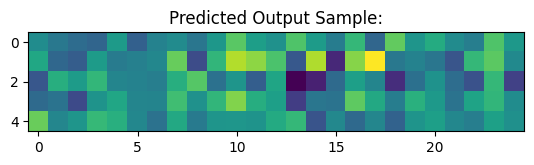

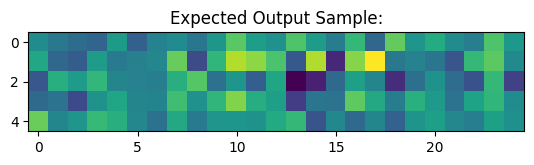

In [43]:
import onnxruntime as ort
import numpy as np

ort_sess = ort.InferenceSession(onnx_model_path, providers=['CPUExecutionProvider'])
onnx_outputs = ort_sess.run(None, {'input': test_inputs})[0]

test_outputs(target_outputs, onnx_outputs)

Automatic pdb calling has been turned OFF


NOTE: most informative metric here is R^2 (aka % explained variance,
R^2<0 implies worse than guessing mean)
sanity R^2:  0.9999999999972274
sanity MAE:  1.8942633062124514e-07
sanity MSE:  5.648959286994916e-14


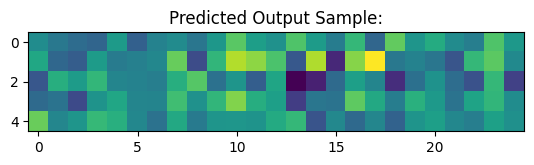

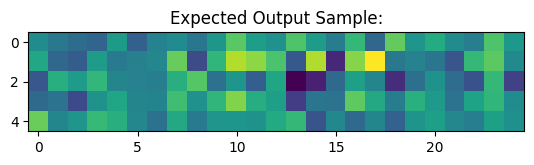

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 25)]              0         
                                                                 
 LAYER_0 (Dense)             (None, 100)               2600      
                                                                 
 LAYER_1 (Activation)        (None, 100)               0         
                                                                 
 LAYER_2 (Dense)             (None, 100)               10100     
                                                                 
 LAYER_3 (Activation)        (None, 100)               0         
                                                                 
 LAYER_4 (Dense)             (None, 100)               10100     
                                                                 
 LAYER_5 (Activation)        (None, 100)               0   

In [49]:
%pdb off
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as L
keras_version = keras.models.load_model(tf_model_path)

actual_output=keras_version(test_inputs)
test_outputs(target_outputs, actual_output)

keras_version.summary()

In [52]:
output = input = L.Input(in_shape[1:])
output = L.Rescaling(1, 0, name='in_wrapping_layer')(output)
#L.Dense(64, activation='selu', name='in_wrapping_layer')(output)
output = keras_version(output)
output = L.Rescaling(1, 0, name='out_wrapping_layer')(output)
#output = L.Dense(64, activation='selu', name='out_wrapping_layer')(output)
keras_wrapper = keras.models.Model(inputs=input, outputs=output)
#keras_wrapper = keras.models.Sequential()
#keras_wrapper.add(L.Dense(64, activation='selu', name='in_wrapping_layer'))
keras_wrapper.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 25)]              0         
                                                                 
 in_wrapping_layer (Rescali  (None, 25)                0         
 ng)                                                             
                                                                 
 model_3 (Functional)        (None, 25)                75825     
                                                                 
 out_wrapping_layer (Rescal  (None, 25)                0         
 ing)                                                            
                                                                 
Total params: 75825 (296.19 KB)
Trainable params: 75825 (296.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
